# Machine Translation English-Hindi Example Using IronMan Seq2Seq

1. [Introduction](#Introduction)
2. [Prerequisites and Preprocessing](#Prequisites-and-Preprocessing)
  1. [Permissions and environment variables](#Permissions-and-environment-variables)
  2. [Data Ingestion](#Data-Ingestion)
3. [Training the Machine Translation model](#Training-the-Machine-Translation-model)
4. [Set up hosting for the model](#Set-up-hosting-for-the-model)
  1. [Import model into hosting](#Import-model-into-hosting)
  2. [Create endpoint configuration](#Create-endpoint-configuration)
  3. [Create endpoint](#Create-endpoint)
  4. [Validate the model for use](#Validate-the-model-for-use)
5. [Use a pretrained model](#Use-a-pretrained-model)

## Introduction

Welcome to our Machine Translation end-to-end example! In this demo, we will train a English-Hindi translation model and will test the predictions on a few examples.

IronMan seq2seq algorithm is built on top of [Sockeye](https://github.com/awslabs/sockeye), a sequence-to-sequence framework for Neural Machine Translation based on MXNet. IronMan Seq2Seq implements state-of-the-art encoder-decoder architectures which can also be used for tasks like Abstractive Summarization in addition to Machine Translation.

To get started, we need to set up the environment with a few prerequisite steps, for permissions, configurations, and so on.

## Prequisites and Preprocessing

### Permissions and environment variables

Here we set up the linkage and authentication to AWS services. There are three parts to this:

1. The credentials and region for the account that's running training. Upload the credentials in the normal AWS credentials file format using the jupyter upload feature. The region must always be `us-west-2` during the Beta program.
2. The roles used to give learning and hosting access to your data. See the documentation for how to specify these.
3. The S3 bucket that you want to use for training and model data.

_Note:_ Credentials for hosted notebooks will be automated before the final release.

In [2]:
import boto3
from time import gmtime, strftime
import time
import numpy as np
import os
import json

# For plotting attention matrix later on
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

In [3]:
os.environ['AWS_DEFAULT_REGION']='us-west-2'
os.environ['AWS_SHARED_CREDENTIALS_FILE'] = os.getcwd() + '/credentials'

s3_access_role = 'arn:aws:iam::317790470510:role/IronManAccessRole'
model_role = 'arn:aws:iam::317790470510:role/IronManAccessRole'  

# ECS Docker image for IM Seq2Seq.
docker_image = "032969728358.dkr.ecr.us-west-2.amazonaws.com/seq2seq:latest"

# S3 bucket that stores training and validation data.
bucket = 'https://s3-us-west-2.amazonaws.com/seq2seq-data/eng-hindi'

### Data Ingestion

We download the [IIT Bombay English-Hindi Parallel Corpus](http://www.cfilt.iitb.ac.in/iitb_parallel/) and store the training and validation dataset in our S3 bucket under **train** and **val** subfolders respectively. The current interface **_(subject to change)_** expects a parallel corpus with 2 files in each of the train and val subfolders (with **source** and **target** keywords in the filename). IronMan Seq2Seq expects already tokenized data (whitespace separated) as the input. The IIT Bombay corpus has already been tokenized for us. However, keep this in mind for any other data set you want to use with Seq2Seq. So, we upload 4 files in the S3 bucket:

For training:
- https://s3-us-west-2.amazonaws.com/seq2seq-data/eng-hindi/train/IITB.en-hi.en.source
- https://s3-us-west-2.amazonaws.com/seq2seq-data/eng-hindi/train/IITB.en-hi.hi.target

For validation:
- https://s3-us-west-2.amazonaws.com/seq2seq-data/eng-hindi/val/dev.en.source
- https://s3-us-west-2.amazonaws.com/seq2seq-data/eng-hindi/val/dev.hi.target

Please note the use of keywords **source** and **target** in the filenames. It is a requirement for IronMan Seq2Seq to recognize the source and target files.

## Training the Machine Translation model

Once we have the data available in the correct format for training, the next step is to actually train the model using the data.

After setting training parameters, we kick off training, and poll for status until training is completed, which in this example, takes between **6-8 hours on p2.8xlarge**. If you want to test it in less than 25-30 min, you can disable the comment on the **`"max_updates":"1100"`** hyperparameter below. However, this will not produce a good model. So, you can use the link below to host a pretrained model.

Please refer to the documentation for full understanding and usage of the hyperparameters.

### Skip to [Use a pretrained model](#Use-a-pretrained-model) to play with a pretrained model

In [4]:
%%time

job_name = 'translation-eng-hindi-' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print("Training job", job_name)

create_training_params = \
{
    "AlgorithmSpecification": {
        "TrainingImage": docker_image,
        "TrainingInputMode": "File"
    },
    "RoleArn": s3_access_role,
    "OutputDataConfig": {
        "S3OutputPath": bucket
    },
    "ResourceConfig": {
        "InstanceCount": 1,
        "InstanceType": "p2.8xlarge",
        "VolumeSizeInGB": 50
    },
    "TrainingJobName": job_name,
    "HyperParameters": {
        "rnn_num_hidden":"512",
        "batch_size":"128",
        "monitor_bleu": "1000",
        "device_ids":"-8",
#         "max_updates":"1100",
        "attention_type":"dot",
        "max_num_checkpoint_not_improved":"2",
        "keep_last_params":"3"
    },
    "StoppingCondition": {
        "MaxRuntimeInHours": 15
    },
    "InputDataConfig": [
        {
            "ChannelName": "train",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": bucket + '/train',
                    "S3DataDistributionType": "FullyReplicated"
                }
            },
        },
        {
            "ChannelName": "validation",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": bucket + '/val',
                    "S3DataDistributionType": "FullyReplicated"
                }
            },
        }
    ]
}

ease = boto3.client('im')
ease.create_training_job(**create_training_params)

status = ease.describe_training_job(TrainingJobName=job_name)['TrainingJobStatus']
print(status)
while status !='Completed' and status!='Failed':
    time.sleep(20)
    status = ease.describe_training_job(TrainingJobName=job_name)['TrainingJobStatus']
    print(status)


Training job translation-eng-hindi-2017-11-03-03-39-57
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress

KeyboardInterrupt: 

In [45]:
print("""
Now wait for the model artifacts to get uploaded to S3
and proceed to the next step after you see %s folder
in your S3 bucket.""" % job_name)


Now wait for the model artifacts to get uploaded to S3
and proceed to the next step after you see translation-eng-hindi-2017-11-03-00-00-28 folder
in your S3 bucket.


## Set up hosting for the model

### Skip to [Use a pretrained model](#Use-a-pretrained-model) to play with a pretrained model

In order to set up hosting, we have to import the model from training to hosting. A common question would be, why wouldn't we automatically go from training to hosting? As we worked through examples of what customers were looking to do with hosting, we realized that the Amazon ML model of hosting was unlikely to be sufficient for all customers.

As a result, we have introduced some flexibility with respect to model deployment, with the goal of additional model deployment targets after launch. In the short term, that introduces some complexity, but we are actively working on making that easier for customers, even before GA.

### Import model into hosting
Next, you register the model with hosting. This allows you the flexibility of importing models trained elsewhere, as well as the choice of not importing models if the target of model creation is AWS Lambda, AWS Greengrass, Amazon Redshift, Amazon Athena, or other deployment target.

In [ ]:
%%time

im = boto3.client('im')

model_name=job_name + '-model'
print(model_name)

info = im.describe_training_job(TrainingJobName=job_name)
model_data = info['ModelArtifacts']['S3ModelArtifacts']
print(model_data)

primary_container = {
    'Image': "032969728358.dkr.ecr.us-west-2.amazonaws.com/seq2seq:latest",
    'ModelDataUrl': model_data
}

create_model_response = im.create_model(
    ModelName = model_name,
    ExecutionRoleArn = model_role,
    PrimaryContainer = primary_container)

print(create_model_response['ModelArn'])

### Create endpoint configuration
At launch, we will support configuring REST endpoints in hosting with multiple models, e.g. for A/B testing purposes. In order to support this, customers create an endpoint configuration, that describes the distribution of traffic across the models, whether split, shadowed, or sampled in some way.

In addition, the endpoint configuration describes the instance type required for model deployment, and at launch will describe the autoscaling configuration.

In [36]:
from time import gmtime, strftime

endpoint_config_name = 'Seq2SeqEndpointConfig-' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print(endpoint_config_name)
create_endpoint_config_response = im.create_endpoint_config(
    EndpointConfigName = endpoint_config_name,
    ProductionVariants=[{
        'InstanceType':'p2.xlarge',
        'MaxInstanceCount':1,
        'MinInstanceCount':1,
        'ModelName':model_name,
        'VariantName':'AllTraffic'}])

print("Endpoint Config Arn: " + create_endpoint_config_response['EndpointConfigArn'])

Seq2SeqEndpointConfig-2017-11-03-00-27-38
Endpoint Config Arn: arn:aws:im:us-west-2:032969728358:endpoint-config/Seq2SeqEndpointConfig-2017-11-03-00-27-38


### Create endpoint
Lastly, the customer creates the endpoint that serves up the model, through specifying the name and configuration defined above. The end result is an endpoint that can be validated and incorporated into production applications. This takes 9-11 minutes to complete.

In [47]:
%%time
import time

endpoint_name = 'Seq2SeqEndpoint-' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print(endpoint_name)
create_endpoint_response = im.create_endpoint(
    EndpointName=endpoint_name,
    EndpointConfigName=endpoint_config_name)
print(create_endpoint_response['EndpointArn'])

resp = im.describe_endpoint(EndpointName=endpoint_name)
status = resp['EndpointStatus']
print("Status: " + status)

while status=='Creating':
    time.sleep(60)
    resp = im.describe_endpoint(EndpointName=endpoint_name)
    status = resp['EndpointStatus']
    print("Status: " + status)

print("Arn: " + resp['EndpointArn'])
print("Status: " + status)

Seq2SeqEndpoint-2017-11-03-01-17-43
arn:aws:im:us-west-2:032969728358:endpoint/Seq2SeqEndpoint-2017-11-03-01-17-43
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: InService
Arn: arn:aws:im:us-west-2:032969728358:endpoint/Seq2SeqEndpoint-2017-11-03-01-17-43
Status: InService
CPU times: user 64 ms, sys: 12 ms, total: 76 ms
Wall time: 9min 2s


## Validate the model for use
Finally, the customer can now validate the model for use. They can obtain the endpoint from the client library using the result from previous operations, and generate predictions from the trained model using that endpoint.

In [48]:
invocation_endpoint = "https://maeveruntime.prod.us-west-2.ml-platform.aws.a2z.com"
runtime = boto3.Session().client(service_name='runtime.maeve', endpoint_url=invocation_endpoint)

In [53]:
%%time
payload = ['how are you ? ' ]

response = runtime.invoke_endpoint(EndpointName=endpoint_name, 
                                   ContentType='application/json', 
                                   Body=json.dumps(payload))

response = response["Body"].read().decode("utf-8")
response = json.loads(response)
print(response)

[{'target': 'आप कैसे हैं ?'}]
CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 363 ms


## Use a pretrained model

#### Creating model, endpoint and endpoint config

In [5]:
%%time
pretrained_model_s3 = "https://s3-us-west-2.amazonaws.com/seq2seq-data/eng-hindi/seq2seq-testing-eng-hindi-2017-11-01-22-26-44/model.tar.gz"

im = boto3.client('im')
model_name = 'EngHindi-'  + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print(model_name)

primary_container = {
    'Image': "032969728358.dkr.ecr.us-west-2.amazonaws.com/seq2seq:latest",
    'ModelDataUrl': pretrained_model_s3
}

create_model_response = im.create_model(
    ModelName = model_name,
    ExecutionRoleArn = model_role,
    PrimaryContainer = primary_container)

print(create_model_response['ModelArn'])

endpoint_config_name = 'EngHindiEndpointConfigOrchid-' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print(endpoint_config_name)
create_endpoint_config_response = im.create_endpoint_config(
    EndpointConfigName = endpoint_config_name,
    ProductionVariants=[{
        'InstanceType':'p2.xlarge',
        'MaxInstanceCount':1,
        'MinInstanceCount':1,
        'ModelName':model_name,
        'VariantName':'AllTraffic'}])

print("Endpoint Config Arn: " + create_endpoint_config_response['EndpointConfigArn'])

endpoint_name = 'EngHindiEndpointOrchid-' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print(endpoint_name)
create_endpoint_response = im.create_endpoint(
    EndpointName=endpoint_name,
    EndpointConfigName=endpoint_config_name)
print(create_endpoint_response['EndpointArn'])

resp = im.describe_endpoint(EndpointName=endpoint_name)
status = resp['EndpointStatus']
print("Status: " + status)

while status=='Creating':
    time.sleep(60)
    resp = im.describe_endpoint(EndpointName=endpoint_name)
    status = resp['EndpointStatus']
    print("Status: " + status)

print("Arn: " + resp['EndpointArn'])
print("Status: " + status)

EngHindi-2017-11-03-04-13-12
arn:aws:im:us-west-2:317790470510:model/EngHindi-2017-11-03-04-13-12
EngHindiEndpointConfigOrchid-2017-11-03-04-13-12
Endpoint Config Arn: arn:aws:im:us-west-2:317790470510:endpoint-config/EngHindiEndpointConfigOrchid-2017-11-03-04-13-12
EngHindiEndpointOrchid-2017-11-03-04-13-12
arn:aws:im:us-west-2:317790470510:endpoint/EngHindiEndpointOrchid-2017-11-03-04-13-12
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: InService
Arn: arn:aws:im:us-west-2:317790470510:endpoint/EngHindiEndpointOrchid-2017-11-03-04-13-12
Status: InService
CPU times: user 60 ms, sys: 4 ms, total: 64 ms
Wall time: 9min 2s


In [6]:
invocation_endpoint = "https://maeveruntime.prod.us-west-2.ml-platform.aws.a2z.com"
runtime = boto3.Session().client(service_name='runtime.maeve', endpoint_url=invocation_endpoint)

In [17]:
payload = ['this is working now.',
           'I love flowers',
           'I will go out',
           'I am your friend' ]

response = runtime.invoke_endpoint(EndpointName=endpoint_name, 
                                   ContentType='application/json', 
                                   Body=json.dumps(payload))

response = response["Body"].read().decode("utf-8")
response = json.loads(response)

In [18]:
response

[{'target': 'यह काम कर रहा है ।'},
 {'target': 'मैं फूलों से प्यार करता हूँ'},
 {'target': 'मैं बाहर जा रहा हूँ'},
 {'target': 'मैं तुम्हारा दोस्त हूँ'}]

### Retrieving the Attention Matrix

Passing `ContentType='application/json;attention_matrix=True'` will return the attention matrix.

In [20]:
payload = ['what is your age ?']

response = runtime.invoke_endpoint(EndpointName=endpoint_name, 
                                   ContentType='application/json;attention_matrix=True', 
                                   Body=json.dumps(payload))

response = response["Body"].read().decode("utf-8")
response = json.loads(response)

source = payload[0]
target = response[0]["target"]
attention_matrix = np.array(response[0]["matrix"])

print("Source: %s \nTarget: %s" % (source, target))

Source: what is your age ? 
Target: आपकी उम्र क्या है ?


In [21]:
# Install the Hindi font for attention matrix
!sudo wget https://cghs.nic.in/mangal.ttf -o /usr/share/fonts/mangal.ttf
hindi_font = FontProperties(fname = 'mangal.ttf')

In [22]:
def plot_matrix(attention_matrix, target, source):
    source_tokens = source.split()
    target_tokens = target.split()
    assert attention_matrix.shape[0] == len(target_tokens)
    plt.imshow(attention_matrix.transpose(), interpolation="nearest", cmap="Greys")
    plt.xlabel("target")
    plt.ylabel("source")
    plt.gca().set_xticks([i for i in range(0, len(target_tokens))])
    plt.gca().set_yticks([i for i in range(0, len(source_tokens))])
    plt.gca().set_xticklabels(target_tokens, fontproperties=hindi_font)
    plt.gca().set_yticklabels(source_tokens)
    plt.tight_layout()

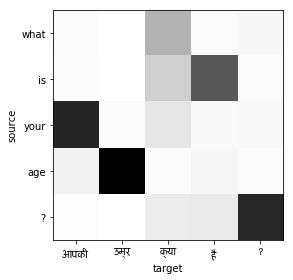

In [23]:
plot_matrix(attention_matrix, target, source)